In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.text as text
from matplotlib.gridspec import GridSpec
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc, roc_auc_score, f1_score, mean_absolute_error, classification_report 
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

Análise Exploratória dos Dados

In [2]:
data_location = "../Data/card_transdata.csv"
data = pd.read_csv(data_location, sep = ",")

In [3]:
data.shape

(1000000, 8)

In [4]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Verificando se há dados nulos

In [5]:
data.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [6]:
data.fraud.unique()

array([0., 1.])

In [7]:
print('\nConjunto de dados, linhas e colunas\n')
print('The shape of the data set is:',data.shape)
print('\n---------------------------------------------\n')

print('\nCheck valores nulos\n')
print('Checking for missing values: \n')
print(pd.isnull(data).sum())
print('\n---------------------------------------------\n')

print('\nEstatísticas\n')
print(data.describe())
print('\n---------------------------------------------\n')

print('\nInformações do dataset\n')
print(data.info())
print('\n---------------------------------------------\n')

print('\nCheck balanceamento da target fraud\n')
print(data['fraud'].value_counts())
print('\n---------------------------------------------\n')


Conjunto de dados, linhas e colunas

The shape of the data set is: (1000000, 8)

---------------------------------------------


Check valores nulos

Checking for missing values: 

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

---------------------------------------------


Estatísticas

       distance_from_home  distance_from_last_transaction  \
count      1000000.000000                  1000000.000000   
mean            26.628792                        5.036519   
std             65.390784                       25.843093   
min              0.004874                        0.000118   
25%              3.878008                        0.296671   
50%              9.967760                        0.998650   
75%             25.743985  

Observando a distribuição dos dados

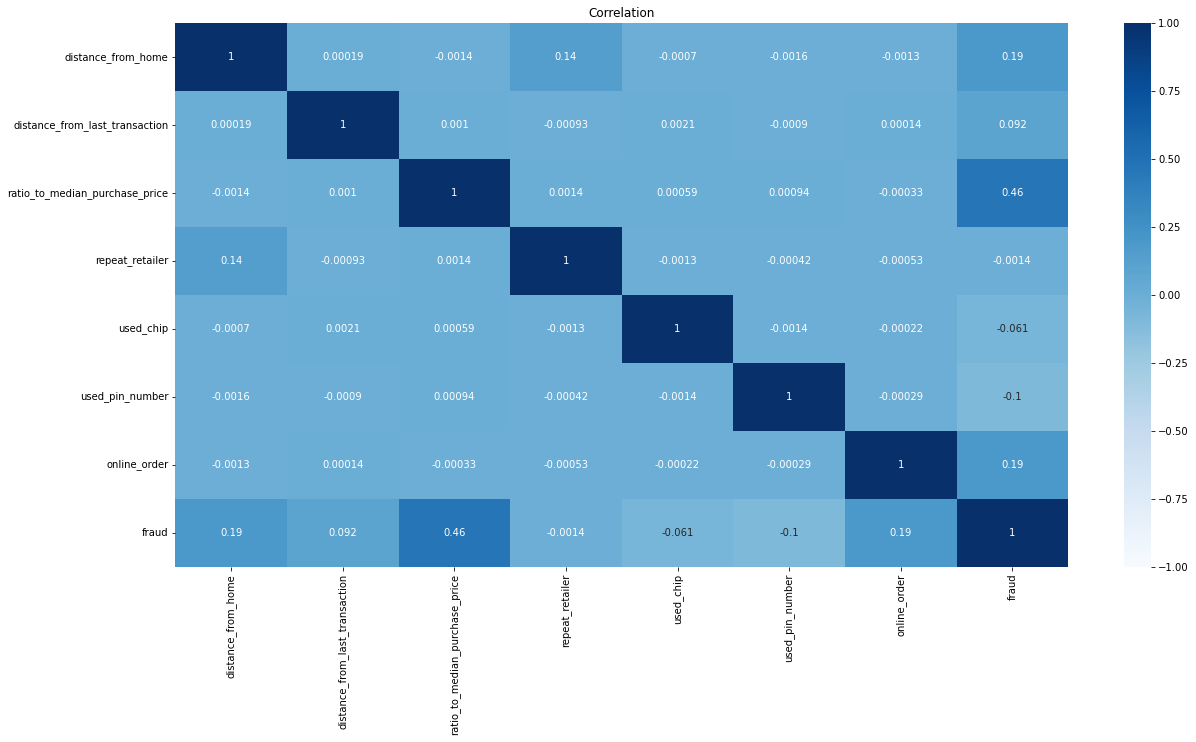

In [8]:
# Quais variáveis estão mais correlacionadas com a variável target?
plt.figure(figsize = (20,10))
plt.title('Correlation')
sns.heatmap(data.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
           );
plt.savefig("Correlation1.png", dpi = 600 )

# Balanceamento da variável target

Vizualização da distribuição dos dados fraudados e não fraudados

fraud
0.0    912597
1.0     87403
dtype: int64

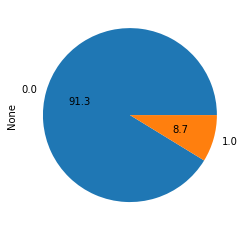

In [9]:
data.value_counts("fraud").plot.pie(autopct = "%.1f")
data.value_counts("fraud")
#plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/pizza_fraud1.png", dpi = 600 )

In [10]:
data.corr()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,0.000193,-0.001374,0.143124,-0.000697,-0.001622,-0.001301,0.187571
distance_from_last_transaction,0.000193,1.000000,0.001013,-0.000928,0.002055,-0.000899,0.000141,0.091917
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000,0.001374,0.000587,0.000942,-0.000330,0.462305
repeat_retailer,0.143124,-0.000928,0.001374,1.000000,-0.001345,-0.000417,-0.000532,-0.001357
used_chip,-0.000697,0.002055,0.000587,-0.001345,1.000000,-0.001393,-0.000219,-0.060975
used_pin_number,-0.001622,-0.000899,0.000942,-0.000417,-0.001393,1.000000,-0.000291,-0.100293
online_order,-0.001301,0.000141,-0.000330,-0.000532,-0.000219,-0.000291,1.000000,0.191973
fraud,0.187571,0.091917,0.462305,-0.001357,-0.060975,-0.100293,0.191973,1.000000


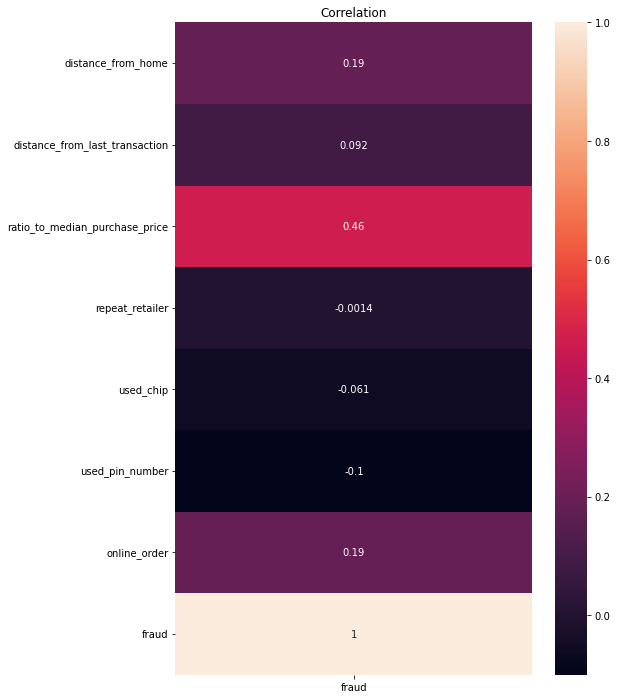

In [11]:
plt.figure(figsize = (8,12))
plt.title('Correlation')
sns.heatmap(data.corr()[['fraud']], 
            annot = True
           );
plt.savefig("Correlation2.png", dpi = 600 )

Criação de uma lista vazia para armazenar as métricas dos modelos

In [12]:
data_all=[]

Reduzindo o tamanho do dataset para 50000 registros

In [13]:
data_fraud= data.sample(n=50000)

# Criação da base de treino e teste

In [14]:
X = data_fraud.drop(columns=['fraud'],axis=1)
y = data_fraud["fraud"]

Split da base reduzida com 30% para teste

In [15]:
dt_fraud_train, dt_fraud_test= train_test_split(data_fraud, test_size=0.3, stratify=y, random_state=12)

Verificando colunas e linhas do dataset de treino e teste

In [16]:
print('Shape Treino: ', dt_fraud_train.shape)
print('Shape teste: ', dt_fraud_test.shape)

Shape Treino:  (35000, 8)
Shape teste:  (15000, 8)


Verificando quantidade de registros fraudados e não fraudados no dataset de treino

In [17]:
dt_fraud_train.fraud.value_counts()

0.0    31932
1.0     3068
Name: fraud, dtype: int64

# Igualando a quantidade de registros de treino usando esquema undersampling

Criação dataset separado com mascara para fraudados e não fraudados no dataset de treino

In [18]:
dt_fraud_train_0=dt_fraud_train[dt_fraud_train.fraud == 0]
dt_fraud_train_1=dt_fraud_train[dt_fraud_train.fraud == 1]

Igualando a quantidade de registros para fraud no modelo de treino

In [19]:
len_fraud=len(dt_fraud_train_1)
print(len_fraud)

3068


In [20]:
dt_fraud_train_0_sample=dt_fraud_train_0.sample(n=len_fraud)

In [21]:
print('Fraud: :', dt_fraud_train_1.shape[0])
print('No Fraud: :', dt_fraud_train_0_sample.shape[0])

Fraud: : 3068
No Fraud: : 3068


Concatenando as duas bases

In [22]:
dt_fraud_train2=pd.concat([dt_fraud_train_1,dt_fraud_train_0_sample],axis=0)

In [23]:
print('Treino: ', dt_fraud_train2.shape)

Treino:  (6136, 8)


Vizualizando a quantidade de registros fraudados e não fraudados em no Treino

fraud
0.0    3068
1.0    3068
dtype: int64

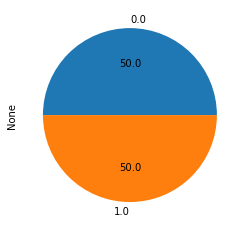

In [24]:
dt_fraud_train2.value_counts("fraud").plot.pie(autopct = "%.1f")
dt_fraud_train2.value_counts("fraud")

Vizualizando a quantidade de registros fraudados e não fraudados em no Test

fraud
0.0    13685
1.0     1315
dtype: int64

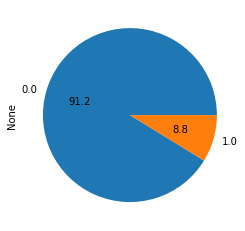

In [25]:
dt_fraud_test.value_counts("fraud").plot.pie(autopct = "%.1f")
dt_fraud_test.value_counts("fraud")

Definindo a matriz de features e a variável target nos modelos de treino e teste

In [26]:
X_train = dt_fraud_train2.drop(columns=['fraud'],axis=1)
y_train = dt_fraud_train2.fraud

In [27]:
X_test = dt_fraud_test.drop(columns=['fraud'],axis=1)
y_test = dt_fraud_test.fraud

Imprimindo tamanho e colunas de treino e teste

In [28]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_train.shape)
print('y_test: ', y_train.shape)

X_train:  (6136, 7)
y_train:  (6136,)
X_test:  (6136, 7)
y_test:  (6136,)


Padronização das features do modelos de treino e de teste

In [29]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Modelo 1: Regressão Logística

Instanciando um objeto da classe LogisticRegression

In [30]:
lr = LogisticRegression()

Ajuste do modelo

In [31]:
lr.fit(X_train_std, y_train)

LogisticRegression()

Visualização dos coeficientes

In [32]:
print(lr.coef_)
print(lr.intercept_)

[[ 2.83959845  2.34567055  6.28066791 -0.49443644 -0.53439554 -1.82356968
   2.1285976 ]]
[0.41773206]


Previsão da acurácia com o modelo treinado

In [33]:
score_train_lr = accuracy_score(y_train, lr.predict(X_train_std))
print('Score train: ', score_train_lr)

Score train:  0.9403520208604954


Matriz de confusão do modelo de treino

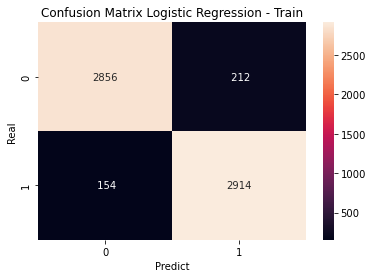

In [34]:
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Logistic Regression - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-LR-Train.png", dpi = 600 )

Observamos no treino que dos 3046 casos positivos de fraud 2922 foram fraudes verdadeiras. Isso implica que nosso classificador está dizendo 94% das detecções de fraudes são positivas.

Previsão da acurácia com o modelo de teste

In [35]:
y_test_pred_lr = lr.predict(X_test_std)

Acurácia do modelo de teste

In [36]:
score_test_lr = accuracy_score(y_test, y_test_pred_lr)
print('Score test: ', score_test_lr)

Score test:  0.9333333333333333


Matriz de confusão do modelo de teste

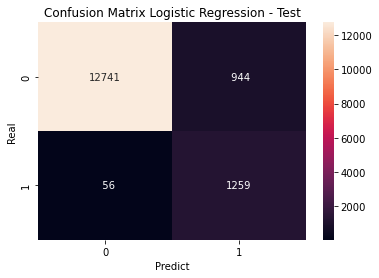

In [37]:
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Logistic Regression - Test')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-LR-test.png", dpi = 600 )

Observamos no treino que dos 12.820 casos positivos de fraudes 61 foram fraudes verdadeiras. Isso implica que nosso classificador está dizendo 93% das detecções de fraudes são positivas.

Métricas do modelo de teste

In [38]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_lr, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       1.00      0.93      0.96     13685
     Fraud 1       0.57      0.96      0.72      1315

    accuracy                           0.93     15000
   macro avg       0.78      0.94      0.84     15000
weighted avg       0.96      0.93      0.94     15000



Inserindo as métricas na lista para armazenamento

In [39]:
m='Logistic Regression'
test_recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_test_pred_lr, pos_label=1)
test_auc_lr = auc(fpr_lr,tpr_lr)
f1_score_lr = f1_score(y_test, y_test_pred_lr)
data_all.append([m,score_train_lr,score_test_lr,test_recall_lr,test_auc_lr,f1_score_lr])

# Modelo 2: Randon Forest

Instanciando a classe Randon Forest

In [40]:
rf=RandomForestClassifier()

Treino do modelo usando os conjuntos de treinamento y_pred=clf.predict(X_test)

In [41]:
rf.fit(X_train_std, y_train)

RandomForestClassifier()

Previsão da acurácia com o modelo de teste

In [42]:
score_train_rf = accuracy_score(y_train, rf.predict(X_train_std))
print('Score train: ', score_train_rf)

Score train:  1.0


Atribuindo A variável y_test_pred a previsão

In [43]:
y_test_pred_rf = rf.predict(X_test_std)

Atribuindo a variável score_test a acurácia

In [44]:
score_test_rf = accuracy_score(y_test, y_test_pred_rf)
print('Score test: ', score_test_rf)

Score test:  0.9992666666666666


Matriz de confusão do modelo de treino

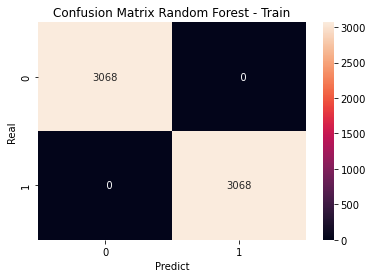

In [45]:
sns.heatmap(confusion_matrix(y_train, rf.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )
font = {'color':  'white',
        'weight': 'normal',
        'size': 10,
        }
plt.title('Confusion Matrix Random Forest - Train')
plt.xlabel('Predict')
plt.ylabel('Real')
plt.savefig("confusion-RF-train.png", dpi = 600 )

Matriz de confusão do modelo de teste

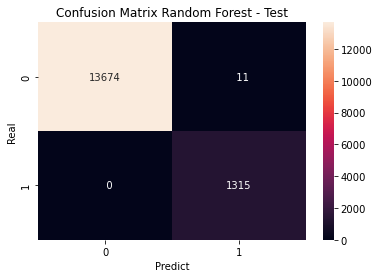

In [46]:
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Random Forest - Test')
plt.xlabel('Predict')
plt.ylabel('Real')
plt.savefig("confusion-RF-test.png", dpi = 600 )

Observando as métricas

In [47]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_rf, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       1.00      1.00      1.00     13685
     Fraud 1       0.99      1.00      1.00      1315

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



Inserindo as métricas na lista para armazenamento

In [48]:
m='Randon Forest'
test_recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_test_pred_rf, pos_label=1)
test_auc_rf = auc(fpr_rf,tpr_rf)
f1_score_rf = f1_score(y_test, y_test_pred_rf)
data_all.append([m,score_train_rf,score_test_rf,test_recall_rf,test_auc_rf,f1_score_rf])

# Modelo 3: KNeighborsClassifier

Escolha da escolher metrica (Euclidean,  Manhattan ou Chebyshev)
Escolher com quantos vizinhos a quantidade de vizinhos próximos pelo modelo de validação cruzada.

In [49]:
# Usamos cross validation co, 5 folds
kf = KFold(n_splits = 5, shuffle = True, random_state = 12)
scores_para_df = []
for i in range(1, 26):
# Em cada iteração, instanciamos o modelo com um hiperparâmetro diferente
    model_euclidean = KNeighborsClassifier(metric = 'euclidean', n_neighbors = i)
    model_manhattan = KNeighborsClassifier(metric = 'manhattan', n_neighbors = i)
    model_chebyshev = KNeighborsClassifier(metric = 'chebyshev', n_neighbors = i)
# cross_val_scores retorna uma matriz de 5 resultados,
# um para cada partição que automaticamente criou CV
    cv_scores = cross_val_score(model_euclidean, X_train_std, y_train, cv = kf)
    cv_scores2 = cross_val_score(model_manhattan, X_train_std, y_train, cv = kf)
    cv_scores3 = cross_val_score(model_chebyshev, X_train_std, y_train, cv = kf)
# Para cada valor de n_neighbours, criamos um dicionário com o valor
# de n_neighbours e a média das pontuações
    dict_row_score = { 'n_neighbors': i, 'euclidean': np.mean(cv_scores),'manhattan': np.mean(cv_scores2),'chebyshev': np.mean(cv_scores3)}

# Salvamos cada um na lista definida fora do loop
    scores_para_df.append(dict_row_score)

De acordo com os vizinhos próximos as 3 melhores accuracy das metricas estão grifadas em amarelo

In [50]:
df_scores = pd.DataFrame(scores_para_df)

In [51]:
df_scores.style.highlight_max(subset=['euclidean','manhattan','chebyshev'])

,n_neighbors,euclidean,manhattan,chebyshev
0,1,0.989244,0.989244,0.987777
1,2,0.986148,0.985659,0.985170
2,3,0.987777,0.987940,0.985984
3,4,0.987125,0.987451,0.986799
4,5,0.985659,0.986799,0.985821
5,6,0.985332,0.985984,0.984517
6,7,0.984843,0.985984,0.984843
7,8,0.984517,0.985495,0.984517
8,9,0.984354,0.984354,0.982888
9,10,0.983702,0.984028,0.982724


Conforme identificado acima qual melhor parâmetro de distância e vizinhos se aplica ao modelo.

In [52]:
knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 1)

Treino do modelo usando a distancia e métrica identificada

In [53]:
knn.fit(X_train_std, y_train);

Previsão com o modelo de teste

In [54]:
y_test_pred_knn = knn.predict(X_test_std)

Previsão valores e a acurácia

In [55]:
accuracy_score(y_test, y_test_pred_knn).round(4)

0.9894

In [56]:
score_train_knn = accuracy_score(y_train, knn.predict(X_train_std))
print('Score train: ', score_train_knn)

Score train:  1.0


In [57]:
score_test_knn = accuracy_score(y_test, y_test_pred_knn)
print('Score test: ', score_test_knn)

Score test:  0.9894


Matriz de confusão modelo treino

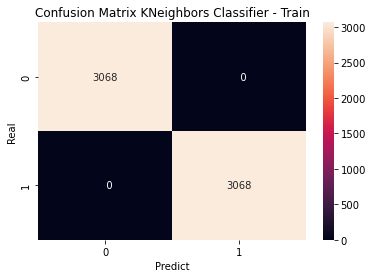

In [58]:
sns.heatmap(confusion_matrix(y_train, knn.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix KNeighbors Classifier - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-knn-train.png", dpi = 600 )

Matriz de confusão modelo teste

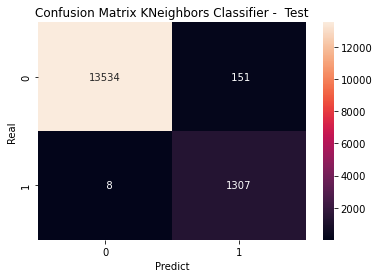

In [59]:
sns.heatmap(confusion_matrix(y_test, knn.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix KNeighbors Classifier -  Test')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-knn-test.png", dpi = 600 )

Observando as métricas

In [60]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_knn, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       1.00      0.99      0.99     13685
     Fraud 1       0.90      0.99      0.94      1315

    accuracy                           0.99     15000
   macro avg       0.95      0.99      0.97     15000
weighted avg       0.99      0.99      0.99     15000



Inserindo as métricas na lista para armazenamento

In [61]:
m='KNN'
test_recall_knn = recall_score(y_test, y_test_pred_knn, pos_label=1)
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_test_pred_knn, pos_label=1)
test_auc_knn = auc(fpr_knn,tpr_knn)
f1_score_knn = f1_score(y_test, y_test_pred_knn)
data_all.append([m,score_train_knn,score_test_knn,test_recall_knn,test_auc_knn,f1_score_knn])

# Modelo 4: Decision Tree Classifier

Intanciando a classe Decison Tree Classifier, definimos o random_state de 12

In [62]:
dt = DecisionTreeClassifier(random_state=12)

Treino do modelo 

In [63]:
dt.fit(X_train_std, y_train)

DecisionTreeClassifier(random_state=12)

Previsão valores e a acurácia

In [64]:
y_test_pred_dt = dt.predict(X_test_std)

Previsão acurácia de treino

In [65]:
score_train_dt = accuracy_score(y_train, dt.predict(X_train_std))
print('Score train: ', score_train_dt)

Score train:  1.0


Previsão acurácia de teste

In [66]:
score_test_dt = accuracy_score(y_test, y_test_pred_dt)
print('Score test: ', score_test_dt)

Score test:  0.999


Imprimindo a media aboluta

In [67]:
mean_abs_dt = mean_absolute_error(y_test, y_test_pred_dt)
print('Mean Absolute Error: ', mean_abs_dt)

Mean Absolute Error:  0.001


Criando a matriz de confusão modelo treino

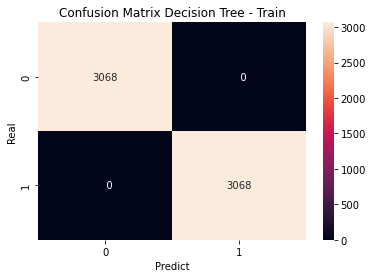

In [68]:
sns.heatmap(confusion_matrix(y_train, dt.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Decision Tree - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-DT-train.png", dpi = 600 )

Criando a matriz de confusão modelo teste

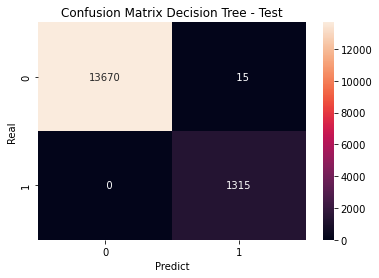

In [69]:
sns.heatmap(confusion_matrix(y_test, dt.predict(X_test_std)), 
            annot = True, 
            fmt = '4d',
           )
plt.title('Confusion Matrix Decision Tree - Test')
plt.xlabel('Predict')
plt.ylabel('Real')
plt.savefig("confusion-DT-test.png", dpi = 600 )

In [70]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_dt, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       1.00      1.00      1.00     13685
     Fraud 1       0.99      1.00      0.99      1315

    accuracy                           1.00     15000
   macro avg       0.99      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



Inserindo as métricas na lista para armazenamento

In [71]:
m='DT'
test_recall_dt = recall_score(y_test, y_test_pred_dt, pos_label=1)
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, y_test_pred_dt, pos_label=1)
test_auc_dt = auc(fpr_dt,tpr_dt)
f1_score_dt = f1_score(y_test, y_test_pred_dt)
data_all.append([m,score_train_dt,score_test_dt,test_recall_dt,test_auc_dt,f1_score_dt])

### Calculando as probabilidades para a previsão 

In [72]:
r_probs = [0 for _ in range (len(y_test))]
lr_probs = lr.predict_proba(X_test_std)
rf_probs = rf.predict_proba(X_test_std)
knn_probs = knn.predict_proba(X_test_std)
dt_probs = dt.predict_proba(X_test_std)

In [73]:
lr_probs = lr_probs[:,1]
rf_probs = rf_probs[:,1]
knn_probs = knn_probs[:,1]
dt_probs = dt_probs[:,1]

In [74]:
r_auc = roc_auc_score(y_test, r_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
dt_auc = roc_auc_score(y_test, dt_probs)

Imprimindo AUROC scores com os modelos Logistic Regression, Randon Forest e Decision Tree

In [75]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Logistic Regression: AUROC = %.3f' % (lr_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('KNeighbors Classifier: AUROC = %.3f' % (knn_auc))
print('Decision Tree: AUROC = %.3f' % (dt_auc))

Random (chance) Prediction: AUROC = 0.500
Logistic Regression: AUROC = 0.980
Random Forest: AUROC = 1.000
KNeighbors Classifier: AUROC = 0.991
Decision Tree: AUROC = 0.999


Calculando a Curva ROC dos modelos

In [76]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, rf_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

Plotando a curva ROC

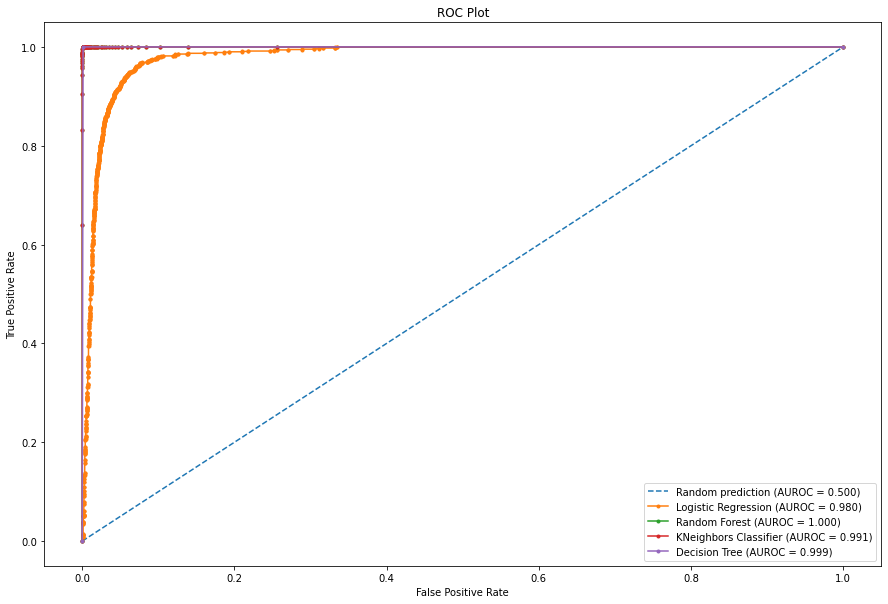

In [77]:
plt.figure(figsize = (15,10))
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUROC = %0.3f)' % lr_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNeighbors Classifier (AUROC = %0.3f)' % knn_auc)
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree (AUROC = %0.3f)' % dt_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.savefig("ROC-plot.png", dpi = 600 )
plt.show()

### Resumo das métricas dos modelos

Atribuindo nome das colunas no dataframe de métricas e imprimindo as informações de todos modelos.

In [78]:
models=['Logistic','Randon Forest', 'KNeighbors','Decision Tree']
pd_scores=pd.DataFrame(data_all,columns=['model','train acuracy','test acuracy','test recall','test_auc','F1 Score'])
print(pd_scores)

                 model  train acuracy  test acuracy  test recall  test_auc  \
0  Logistic Regression       0.940352      0.933333     0.957414  0.944217   
1        Randon Forest       1.000000      0.999267     1.000000  0.999598   
2                  KNN       1.000000      0.989400     0.993916  0.991441   
3                   DT       1.000000      0.999000     1.000000  0.999452   

   F1 Score  
0  0.715748  
1  0.995835  
2  0.942661  
3  0.994329  


In [79]:
pd_scores.style.format({"train score": "${:20,.0f}",
                 "test score": "${:20,.0f}",
                 "test recall": "${:20,.0f}",
                 "test_auc":"${:20,.0f}",
                 "F1 Score":"${:20,.0f}",
                })\
                 .format({"model": lambda x:x.lower()})\
                 .background_gradient(cmap='Blues')

,model,train acuracy,test acuracy,test recall,test_auc,F1 Score
0,logistic regression,0.940352,0.933333,0.957414,0.944217,0.715748
1,randon forest,1.000000,0.999267,1.000000,0.999598,0.995835
2,knn,1.000000,0.989400,0.993916,0.991441,0.942661
3,dt,1.000000,0.999000,1.000000,0.999452,0.994329


## Diagramas de Confiabilidade

Vizualização de quão bem calibradas as probabilidades previstas estão usando curvas de calibração nos modelos de treino

In [80]:
gnb = GaussianNB()

clf_list = [
    (lr, "Logistic"),
    (rf, "RandomForest"),
    (knn, "KNeighbors"),
    (gnb, "Naive Bayes"),
    (dt, "DecisionTree")
]



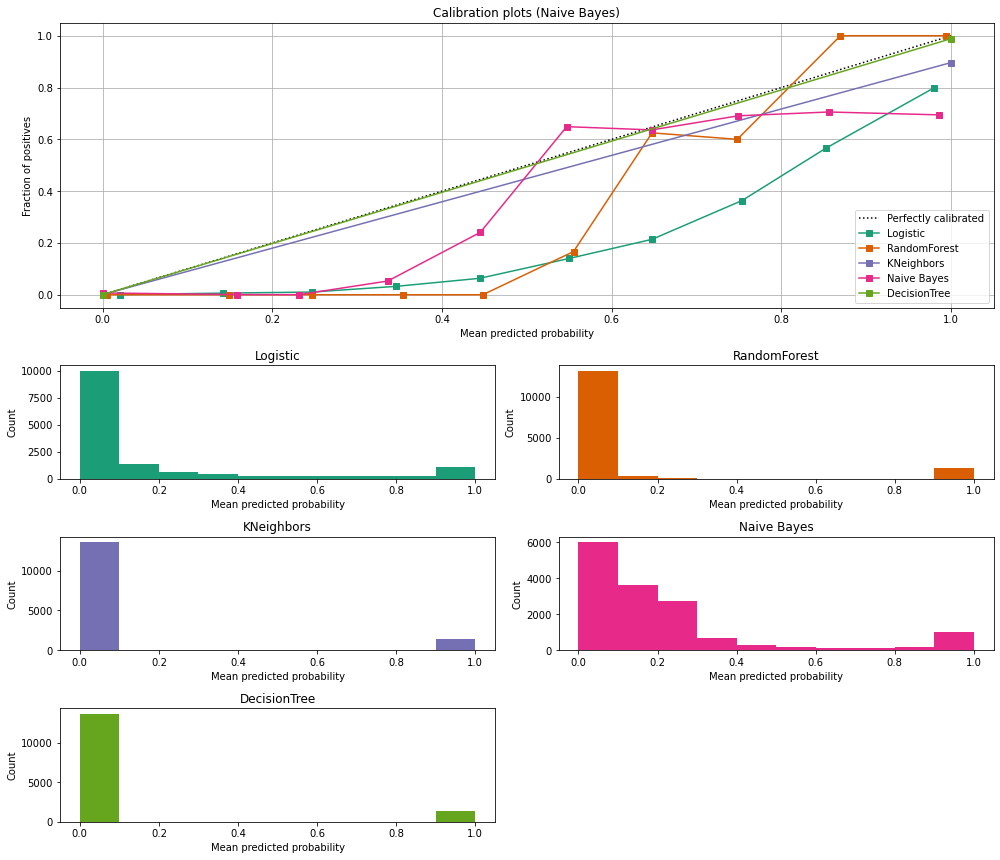

In [81]:
fig = plt.figure(figsize=(14, 14))
gs = GridSpec(6, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train_std, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_std,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (5, 0)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.style.use('default')
plt.savefig("CalibrationDisplay-plot.png", dpi = 1200 )
plt.show()
